# Díaz Alvarado Daniel Alejandro
# Zavaleta Guerrero Joshua Iván

In [3]:
# Cargar dataset y hacer el split (conjunto de entrenamiento y validación)
import torch
import torch.nn as nn  
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset 
import numpy as np
import random as rand
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.ToTensor()
])

full_train_dataset = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=transform
)

rng = np.random.default_rng(42)
indices = rng.choice(len(full_train_dataset), 20000, replace=False)
reduced_dataset = Subset(full_train_dataset, indices)

train_size = int(0.9 * len(reduced_dataset))
val_size = len(reduced_dataset) - train_size

train_dataset, val_dataset = random_split(
    reduced_dataset,
    [train_size, val_size],
    generator = torch.Generator().manual_seed(42) # Para garantizar reproducibilidad
)

In [4]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
Tesla T4


In [5]:
# CREAR DATALOADERS

def crear_dataloaders(batch_size, seed=42):
    g = torch.Generator()
    g.manual_seed(seed)

    train_loader = DataLoader(
        train_dataset,
        batch_size = batch_size,
        shuffle = True,
        generator = g
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size = batch_size,
        shuffle = False
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size = batch_size,
        shuffle = False
    )
    
    return train_loader, val_loader, test_loader

In [6]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

18000
2000
10000


In [7]:
from collections import Counter # Estructura de datos para contar frecuencias de elementos

labels1 = [train_dataset[i][1] for i in range(len(train_dataset))]
labels2 = [val_dataset[i][1] for i in range(len(val_dataset))]
counts1 = Counter(labels1)
counts2 = Counter(labels2)

print(counts1)
print(counts2)

Counter({5: 1844, 2: 1833, 4: 1820, 0: 1801, 3: 1799, 1: 1794, 6: 1791, 7: 1788, 8: 1774, 9: 1756})
Counter({9: 226, 1: 215, 0: 209, 3: 209, 8: 195, 6: 193, 5: 193, 7: 191, 2: 189, 4: 180})


In [8]:
# Adaptación de evaluate()
def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad(): # with es un manejador de contexto. Específicamente aquí dice que durante este bloque que aplique esta configuración especial (no calcular gradientes)
        for X, y in loader:
            X = X.to(device)
            y = y.to(device)

            outputs = model(X)
            _, predicted = torch.max(outputs, 1)

            total += y.size(0)
            correct += (predicted == y).sum().item()

    return correct / total


In [9]:
class SimpleCNN(nn.Module): # nn.Module es la madre de todas las redes
    def __init__(self):
        super().__init__() # Conecta la clase con todas las funciones internas de PyTorch
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    # Define el camino que siguen los datos desde que entran hasta que se obtiene un resultado
    def forward(self, x):
        
        # Capas de extracción (Convolución + Activación + Pooling)
        x = self.pool(F.relu(self.conv1(x)))  # (N,16,14,14)
        x = self.pool(F.relu(self.conv2(x)))  # (N,32,7,7)
        
        # Aplanado o flatten
        x = x.view(x.size(0), -1)   
        
        # Capas de decisión (fully connected)           
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [10]:
def _train_and_evaluate(model, train_loader, val_loader, device, epochs, patience):
    """
    Función auxiliar para entrenar y evaluar un modelo con early stopping.
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()
    
    best_val_acc = 0
    patience_counter = 0
    
    for epoch in range(epochs):
        # Entrenar
        model.train()
        total_loss = 0
        
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            
            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        
        # Evaluar
        model.eval()
        correct = 0
        total = 0
        
        with torch.no_grad():
            val_loss = 0
            total = 0
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                outputs = model(X)
                loss = criterion(outputs, y)
                val_loss += loss.item() * y.size(0)
                total += y.size(0)
        
        val_loss /= total        
        val_acc = correct / total
        
        print(f'    Epoch {epoch+1}/{epochs}: Loss train={avg_loss:.4f}, Val Acc={val_acc:.4f}, Loss val={val_loss:.4f}')
        
        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'    Early stopping en época {epoch+1}')
                break
    
    return best_val_acc

In [11]:
def fitness(model, train, val, device, epochs=2, 
           penalize_complexity=True, alpha=0.0001,
           patience=2):
    """    
    Args:
        model: Modelo a evaluar
        train: DataLoader de entrenamiento (o dataset completo si use_cv=True)
        val: DataLoader de validación (ignorado si use_cv=True)
        device: Dispositivo (cuda/cpu)
        epochs: Número de épocas de entrenamiento
        use_cv: Si True, usa validación cruzada
        k_folds: Número de folds para CV
        penalize_complexity: Si True, penaliza modelos grandes
        alpha: Factor de penalización por complejidad
        patience: Paciencia para early stopping
    
    Returns:
        float: Score de fitness
    """
    # Entrenamiento simple
    acc = _train_and_evaluate(model, train, val, device, epochs, patience)
    
    # Penalización por complejidad 
    if penalize_complexity:
        num_params = sum(p.numel() for p in model.parameters()) # Cuenta el número total de parámetros dentro de la arquitectura 
        fitness_score = acc - alpha * (num_params / 1e6)
        print(f"  Parámetros: {num_params:,} | Acc: {acc:.4f} | Fitness penalizado: {fitness_score:.4f}")
    else:
        fitness_score = acc
    
    # Limpiar memoria
    del model
    torch.cuda.empty_cache() if torch.cuda.is_available() else None
    
    return fitness_score


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [13]:
# model1 = SimpleCNN().to(device)
# model2 = SimpleCNN().to(device)

# s1 = fitness(model1, train_loader, val_loader, device, epochs=1)
# s2 = fitness(model2, train_loader, val_loader, device, epochs=1)

# print(s1, s2)


## Definición del genoma

GENES:

1. Número de capas convolucionales [1,2,3]

2. Tamaño del kernel [3,5]

3. Funciones de activación [ReLU, ELU, LeakyReLU]

4. Número de filtros [16,32]

5. Tamaño de batch size [32,64,128]

nn.ModuleList() es una lsita especial de PyTorch diseñada para guardar capas de forma que el modelo las reconozca. Si se usa una lista normal, PyTorch no verá las capas que se guarden dentro, no moverá sus pesos a la GPU y bo las entrenará. Se usa cuando se quiere crear una red con un número variable de capas o cuando quieres crear capas iguales sin escribir cada línea a mano.

x.view(1, -1): Estira el resultado final (el "cubo" de datos) en una sola fila.

.shape[1]: Pregunta: "¿Cuántos números hay en esta fila?".

Ese número se guarda en self.flatten_dim.

In [14]:
# Parametrizar la CNN
class ParametricCNN(nn.Module): # nn.Module es la madre de todas las redes
    def __init__(self, no_capas, kernel_size, activation, base_filters):
        super().__init__() # Conecta la clase con todas las funciones internas de PyTorch
        
        self.activation = activation
        self.convs = nn.ModuleList() 
        self.pool = nn.MaxPool2d(2, 2)
        
        in_channels = 3
        
        for i in range(no_capas):
            out_channels = base_filters * (2**i)
            self.convs.append(
                nn.Conv2d(
                    in_channels,
                    out_channels,
                    kernel_size=kernel_size,
                    padding = kernel_size // 2
                )
            )
            in_channels = out_channels
            
        # Inferir tamaño del flatten automáticamente (calcular automáticamente el número de neuronas de entrada de la capa lineal)
        with torch.no_grad():
            dummy = torch.zeros(1, 3, 32, 32) # Crea una sola imagen falsa llena de ceros de 3 canales de tamaño 32x32
            
            # Simular el recorrido de la red
            x = dummy
            for conv in self.convs:
                x = self.pool(self.activation(conv(x)))
            self.flatten_dim = x.view(1, -1).shape[1]

        self.fc1 = nn.Linear(self.flatten_dim, 128)
        self.fc2 = nn.Linear(128, 10)

    # Define el camino que siguen los datos desde que entran hasta que se obtiene un resultado
    def forward(self, x):
        
        # Capas de extracción (Convolución + Activación + Pooling)
        for conv in self.convs:
            x = self.pool(self.activation(conv(x)))
        
        # Aplanado o flatten
        x = x.view(x.size(0), -1)   
        
        # Capas de decisión (fully connected)           
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [15]:
# GENOMA 
genoma = {
    "no_capas": [2,3,4],
    "base_filters": [16,32,64],
    "kernel_size": [3,5],
    "activation": ["relu", "leaky_relu"],
    "batch_size": [32,64,128]
}

activation_map = {
    "relu": nn.ReLU(),
    "leaky_relu": nn.LeakyReLU(0.1)
}

In [16]:
def crear_poblacion(no_individuos):
    poblacion = []
    
    for _ in range(no_individuos):
        individuo = [
            rand.choice(genoma["no_capas"]),
            rand.choice(genoma["base_filters"]),
            rand.choice(genoma["kernel_size"]),
            rand.choice(genoma["activation"]),
            rand.choice(genoma["batch_size"])
        ]
        
        poblacion.append(individuo)
    
    return poblacion

In [17]:
def decodificacion(individuo):
    no_capas, base_filters, kernel_size, activation, batch_size = individuo
    activation = activation_map[activation]
    modelo = ParametricCNN(no_capas, kernel_size, activation, base_filters).to(device)
    train, val, test = crear_dataloaders(batch_size)
    
    return modelo, train, val, test
    

In [18]:
def ruleta (poblacion, fit):
    # Función para escoger a los padres y determinar si se cruzan o no
    
    if min(fit)<0:
        fit = [0 for f in fit if f<0]
    
    probabilidad_cruza = 0.85
    
    fit_total = sum(fit)
    fit_ponderada = [i/fit_total for i in fit]
    
    random1 = rand.uniform(0,1)
    padres = []
    acumulada = 0
    for i, fit_individuo in enumerate(fit_ponderada):
        acumulada += fit_individuo 
        if acumulada >= random1:
            padres.append(poblacion[i])
            break
    
    acumulada = 0
    
    while len(padres) != 2:
        random2 = rand.uniform(0,1)
        for i, fit_individuo in enumerate(fit_ponderada):
            acumulada += fit_individuo
            if acumulada >= random2 and poblacion[i] not in padres:
                padres.append(poblacion[i])
                break
            
    random_cruza = rand.uniform (0,1)
    
    if probabilidad_cruza >= random_cruza:
        return padres, True
    else:
        return padres, False

In [19]:
def mutacion(hijo1, hijo2):
    prob_mutacion = 0.1
    lista = list(genoma.values())

    var1 = [rand.uniform(0,1) for _ in range(len(hijo1))] # Se toma el tamaño de cualquier hijo para ver de cuánto va a ser la variable aleatoria
    var2 = [rand.uniform(0,1) for _ in range(len(hijo1))]

    for i in range(len(hijo1)):
        if prob_mutacion >= var1[i]:
            hijo1[i] = rand.choice(lista[i])
        if prob_mutacion >= var2[i]:
            hijo2[i] = rand.choice(lista[i])
    
    return hijo1, hijo2

In [20]:
# El proceso de cruza (según lo visto en clase), se puede hacer con estos métodos: recombinación uniforme, cruza uniforme, cruza un punto, cruza de 2 puntos 
def cruza(padres):
    random = [rand.uniform(0,1) for _ in range(len(padres[0]))] # Se toma el tamaño de cualquoier padre para ver de cuánto va a ser la variable aleatoria
    padre1 = padres[0]
    padre2 = padres[1]
    hijo1 = []
    hijo2 = []
    
    for i in range(len(padre1)):
        if random[i] <= 0.5:
            hijo1.append(padre1[i])
            hijo2.append(padre2[i])
        
        else:
            hijo1.append(padre2[i])
            hijo2.append(padre1[i]) 
            
    return mutacion(hijo1, hijo2)

In [21]:
# CICLO PRINCIPAL

no_poblacion = 16
poblacion = crear_poblacion(no_poblacion)
iteraciones = 20
# N mejores individuos para que no haya problema al momento de generar la nueva población
elite_size = 2

best_history = []
avg_history = []
mejor_global_individuo = None
mejor_global_fitness = 0

for i in range(iteraciones):
    
    print(f"Generación: {i}")
    print(f"Población actual: \n{poblacion}")
    
    fit = []
    
    for individuo in poblacion:
        modelo, train_loader, val_loader, _ = decodificacion(individuo)
        
        fitness_score = fitness(modelo, train_loader, val_loader, device, epochs=10, patience=2, penalize_complexity=True)
        
        fit.append(fitness_score)
    
    print(f"Fitness: \n{fit}")
    
    if max(fit) > mejor_global_fitness:
        mejor_global_fitness = max(fit)
        mejor_global_individuo = poblacion[fit.index(max(fit))].copy()
    
    indices_ordenados = sorted(range(len(fit)), key=lambda i: fit[i], reverse=True)
    
    elite = [poblacion[i] for i in indices_ordenados[:elite_size]]
    
    nueva_poblacion = elite.copy()
    
    while len(nueva_poblacion) < no_poblacion:
        padres, flag = ruleta(poblacion, fit)
        
        if flag:
            hijo1, hijo2 = cruza(padres)
            nueva_poblacion.append(hijo1) 
            nueva_poblacion.append(hijo2)
        else:
            nueva_poblacion.append(padres[0])
            nueva_poblacion.append(padres[1])
            
    poblacion = nueva_poblacion
    best_history.append(max(fit))
    avg_history.append(sum(fit) / len(fit))

print("GENERACIÓN FINAL")
print(f"Población final: \n{poblacion}")

fit = []

for individuo in poblacion:
    modelo, train_loader, val_loader, test_loader = decodificacion(individuo)
    fitness_score = fitness(modelo, train_loader, val_loader, device, epochs=10, patience=2, penalize_complexity=True)
        
    fit.append(fitness_score)

print(f"Fitness: \n{fit}")

if max(fit) > mejor_global_fitness:
    mejor_global_fitness = max(fit)
    mejor_global_individuo = poblacion[fit.index(max(fit))].copy()
    
best_history.append(max(fit))
avg_history.append(sum(fit) / len(fit))

        

Generación: 0
Población actual: 
[[3, 64, 3, 'leaky_relu', 32], [3, 32, 5, 'relu', 128], [3, 16, 5, 'leaky_relu', 128], [3, 16, 5, 'relu', 32], [2, 32, 3, 'relu', 128], [4, 64, 5, 'leaky_relu', 32], [2, 64, 5, 'leaky_relu', 64], [3, 16, 3, 'relu', 64], [3, 32, 5, 'relu', 128], [2, 32, 5, 'leaky_relu', 64], [2, 32, 5, 'relu', 64], [2, 32, 5, 'leaky_relu', 64], [4, 32, 5, 'relu', 128], [3, 16, 5, 'leaky_relu', 128], [4, 32, 5, 'leaky_relu', 64], [4, 64, 3, 'leaky_relu', 32]]
    Epoch 1/10: Loss=1.5907, Val Acc=0.5455
    Epoch 2/10: Loss=1.1475, Val Acc=0.6200
    Epoch 3/10: Loss=0.8934, Val Acc=0.6635
    Epoch 4/10: Loss=0.6832, Val Acc=0.6950
    Epoch 5/10: Loss=0.5071, Val Acc=0.7125
    Epoch 6/10: Loss=0.3573, Val Acc=0.7000
    Epoch 7/10: Loss=0.2292, Val Acc=0.7170
    Epoch 8/10: Loss=0.1505, Val Acc=0.6965
    Epoch 9/10: Loss=0.1255, Val Acc=0.6995
    Early stopping en época 9
  Parámetros: 896,522 | Acc: 0.7170 | Fitness penalizado: 0.7169
    Epoch 1/10: Loss=1.8479, Va

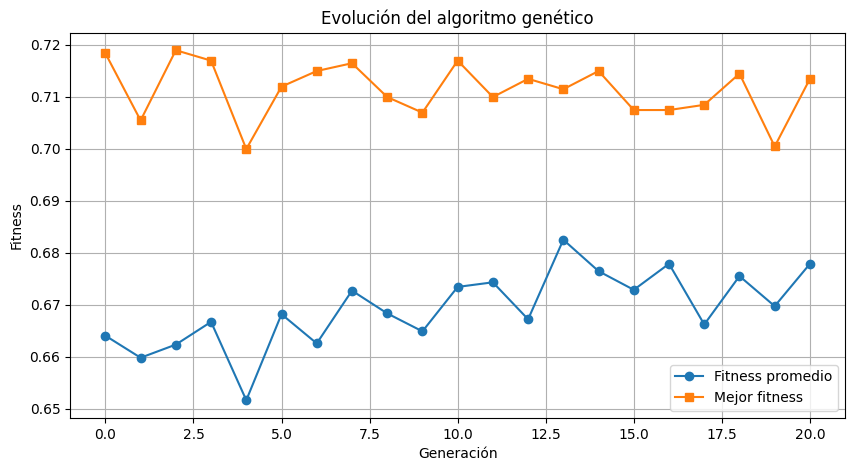

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(avg_history, label="Fitness promedio", marker="o")
plt.plot(best_history, label="Mejor fitness", marker="s")
plt.xlabel("Generación")
plt.ylabel("Fitness")
plt.title("Evolución del algoritmo genético")
plt.legend()
plt.grid(True)
plt.show()


In [2]:
def evaluate_loss(model, loader, device):
    criterion = nn.CrossEntropyLoss()
    model.eval()
    total_loss = 0
    total = 0

    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            loss = criterion(outputs, y)
            total_loss += loss.item() * y.size(0)
            total += y.size(0)

    return total_loss / total


In [25]:
print(f"\nMejor arquitectura:")
print(f"Individuo: {mejor_global_individuo}")
print(f"Fitness (validación): {mejor_global_fitness:.4f}")

# Entrenar el modelo final con más épocas 
modelo_final, train_loader, val_loader, test_loader = decodificacion(mejor_global_individuo)

fitness_final = fitness(modelo_final, train_loader, val_loader, device, epochs=20, patience=5, penalize_complexity=True)

test_accuracy = evaluate(modelo_final, test_loader, device)

print(f"RESULTADO FINAL:")
print(f"Accuracy en VALIDACIÓN: {fitness_final:.4f}")
print(f"Accuracy en TEST: {test_accuracy:.4f}")



Mejor arquitectura:
Individuo: [3, 64, 3, 'leaky_relu', 128]
Fitness (validación): 0.7189
    Epoch 1/20: Loss=1.7529, Val Acc=0.4720
    Epoch 2/20: Loss=1.3307, Val Acc=0.5660
    Epoch 3/20: Loss=1.1083, Val Acc=0.6090
    Epoch 4/20: Loss=0.9449, Val Acc=0.6360
    Epoch 5/20: Loss=0.7974, Val Acc=0.6665
    Epoch 6/20: Loss=0.6680, Val Acc=0.6870
    Epoch 7/20: Loss=0.5351, Val Acc=0.6925
    Epoch 8/20: Loss=0.4192, Val Acc=0.7120
    Epoch 9/20: Loss=0.2974, Val Acc=0.7005
    Epoch 10/20: Loss=0.2078, Val Acc=0.6990
    Epoch 11/20: Loss=0.1341, Val Acc=0.7050
    Epoch 12/20: Loss=0.0918, Val Acc=0.6880
    Epoch 13/20: Loss=0.0571, Val Acc=0.6925
    Early stopping en época 13
  Parámetros: 896,522 | Acc: 0.7120 | Fitness penalizado: 0.7119
RESULTADO FINAL:
Accuracy en VALIDACIÓN: 0.7119
Accuracy en TEST: 0.6911
